In [1]:
from dask.distributed import LocalCluster
# from dask_jobqueue import SLURMCluster
from dask.distributed import Client

cluster = LocalCluster()
# cluster = SLURMCluster(cores=24, name='test', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='128GB', interface='ib0'
#                       ) 
# cluster.scale(24)
# # cluster.adapt(minimum=10, maximum=196)

client = Client(cluster)
# client = Client(scheduler_file="/home/ad/briolf/scheduler.json")
# client = Client()
client

/scratch/cnt0024/hmg2840/tuchida/mars4/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42038 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:44091 Dashboard: http://127.0.0.1:42038/status,Cluster Workers: 8 Cores: 56 Memory: 270.19 GB


In [2]:
!squeue -u tuchida

import time
nb_workers = 0
while True:
    nb_workers = len(client.scheduler_info()["workers"])
    if nb_workers >= 4:
        break
    time.sleep(1)
print(nb_workers)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          11640573      visu      viz  tuchida  R       2:35      1 n4366
8


In [3]:
import xarray as xr
import numpy as np
import numcodecs
import xscale
import gsw
import sys
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os.path as op
from xhistogram.xarray import histogram as xhist

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
ddir = '/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-BLBT02-S/'
xtra = '/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-BLBT02X-S/'
scratch = '/scratch/cnt0024/hmg2840/tuchida/temp'
adac = '/scratch/cnt0024/hmg2840/tuchida/SWOT-AdAC/'

In [11]:
regionsy = np.array([[1514-1,2276-1],
                     [1544-1,2278-1],
                     [1908-1,2582-1]
                    ], dtype=int)
regionsx = np.array([[1194-1,1804-1],   # GULFSTR
                     [2664-1,3270-1],   # NANFL
                     [5750-1,6323-1]    # MEDWEST
                    ], dtype=int)
regions = ['GULFSTR','NANFL','MEDWEST']
variables = ['sossheig', 'sosstsst', 'sosaline', 
             'qt_oce', 'sowaflup',
             'sozocrtx', 
             'sozotaux', 
             'somecrty', 
             'sometauy', 
            ]

tchunk = -1
xchunk = 100
ychunk = 100

<xarray.Dataset>
Dimensions:       (x: 510, y: 610, z: 300)
Dimensions without coordinates: x, y, z
Data variables:
    nav_lon       (y, x) float32 -0.39182127 -0.3751197 ... 8.474864 8.491639
    nav_lat       (y, x) float32 35.77988 35.77966 ... 43.00177 43.000957
    nav_lev       (z) float32 ...
    time_counter  float64 ...
    tmask         (z, y, x) int8 ...
    umask         (z, y, x) int8 ...
    vmask         (z, y, x) int8 ...
    fmask         (z, y, x) int8 ...
    tmaskutil     (y, x) int8 ...
    umaskutil     (y, x) int8 ...
    vmaskutil     (y, x) int8 ...
    fmaskutil     (y, x) int8 ...
    glamt         (y, x) float32 ...
    glamu         (y, x) float32 ...
    glamv         (y, x) float32 ...
    glamf         (y, x) float32 ...
    gphit         (y, x) float32 ...
    gphiu         (y, x) float32 ...
    gphiv         (y, x) float32 ...
    gphif         (y, x) float32 ...
    e1t           (y, x) float64 ...
    e1u           (y, x) float64 ...
    e1v           (y, x) float64 ...
    e1f           (y, x) float64 ...
    e2t           (y, x) float64 ...
    e2u           (y, x) float64 ...
    e2v           (y, x) float64 ...
    e2f           (y, x) float64 ...
    ff            (y, x) float64 ...
    mbathy        (y, x) int16 ...
    misf          (y, x) int16 ...
    isfdraft      (y, x) float32 ...
    e3t_0         (z, y, x) float64 ...
    e3u_0         (z, y, x) float64 ...
    e3v_0         (z, y, x) float64 ...
    e3w_0         (z, y, x) float64 ...
    gdept_0       (z, y, x) float32 ...
    gdepu         (z, y, x) float32 ...
    gdepv         (z, y, x) float32 ...
    gdepw_0       (z, y, x) float32 ...
    gdept_1d      (z) float64 ...
    gdepw_1d      (z) float64 ...
    e3t_1d        (z) float64 ...
    e3w_1d        (z) float64 ...
Attributes:
    file_name:  mesh_mask.nc
    TimeStamp:  13/07/2018 22:32:53 +0200

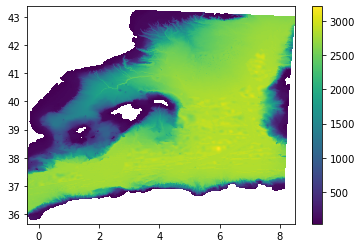

In [9]:
region = 3
ys,ye = regionsy[region-1]
xs,xe = regionsx[region-1]

dsmask = xr.open_dataset(op.join(ddir,'../eNATL60-I/mesh_mask_eNATL60_3.6.nc')
                        ).isel(t=0,y=slice(ys,ye),x=slice(xs,xe))
gdepw = xr.open_dataset(op.join(scratch,'gdepw_eNATL60.nc')
                       ).gdepw.isel(y=slice(ys,ye),x=slice(xs,xe))

fig, ax = plt.subplots()
im = ax.pcolormesh(dsmask.nav_lon, dsmask.nav_lat, gdepw.where(gdepw>0.))
fig.colorbar(im)
dsmask

In [10]:
# dirs = np.arange(669601,756000,43200,dtype=int)
# days = np.concatenate((np.arange(12,32,dtype=int), np.arange(1,6,dtype=int))).reshape((5,5))
# days = np.arange(6,31, dtype=int).reshape((5,5))
# dirs = np.repeat(np.array([1274401]),days.shape[0]+1)
# months = np.array([8,9,10], dtype=str)
# days = np.concatenate((np.concatenate((np.arange(1,32),np.arange(1,31))),np.arange(1,32)))
# mandd = {'8':np.arange(1,32), '9':np.arange(1,31), '10':np.arange(1,32)}
mandd = {'2':np.arange(1,29), '3':np.arange(1,32), '4':np.arange(1,31)}
# print(days,dirs)
mandd.keys()

dict_keys(['2', '3', '4'])

In [11]:
ks = 2
month = 7
dm = 1
year = 2010

for k in range(ks,len(dirs)-1):
    if k == 2:
        dd = days[k,-1:]
    else:
        dd = days[k]
#     dd = days[k]
    for i in dd:
        j = month
        l = j
        m = month+dm
        if i < days[0,0]:
            l = m
        
        ssh = xr.open_dataset(op.join(xtra,
                    '%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridT-2D_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k], 
                                         # 1440721,
                                         int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,
                                         # 25,
                                         days[-1,-1],
                                         year,l,i,year,l,i))
                             ).sossheig.isel(y=slice(ys,ye),x=slice(xs,xe)).chunk({'time_counter':tchunk,'y':ychunk,'x':xchunk})
        taux = xr.open_dataset(op.join(xtra,
                    '%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridU-2D_%4d%02d%02d-%4d%02d%02d.nc' 
                                       % (dirs[k], 
                                          # 1440721,
                                          int(dirs[k]+10800*days.shape[0]-1),
                                          year,j,days[0,0],year,m,
                                          # 25,
                                          days[-1,-1],
                                          year,l,i,year,l,i))
                              ).sozotaux.isel(y=slice(ys,ye),x=slice(xs,xe)).chunk({'time_counter':tchunk,'y':ychunk,'x':xchunk})
        tauy = xr.open_dataset(op.join(xtra,
                    '%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridV-2D_%4d%02d%02d-%4d%02d%02d.nc' 
                                       % (dirs[k], 
                                          # 1440721,
                                          int(dirs[k]+10800*days.shape[0]-1),
                                          year,j,days[0,0],year,m,
                                          # 25,
                                          days[-1,-1],
                                          year,l,i,year,l,i))
                              ).sometauy.isel(y=slice(ys,ye),x=slice(xs,xe)).chunk({'time_counter':tchunk,'y':ychunk,'x':xchunk})
        dsTflx = xr.open_dataset(op.join(xtra,
                    '%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_flxT_%4d%02d%02d-%4d%02d%02d.nc' 
                                         % (dirs[k], 
                                            # 1440721,
                                            int(dirs[k]+10800*days.shape[0]-1),
                                            year,j,days[0,0],year,m,
                                            # 25,
                                            days[-1,-1],
                                            year,l,i,year,l,i)),
                                ).isel(y=slice(ys,ye),x=slice(xs,xe))
        htot = dsTflx.qt_oce.chunk({'time_counter':tchunk,'y':ychunk,'x':xchunk})
        stot = dsTflx.sowaflup.chunk({'time_counter':tchunk,'y':ychunk,'x':xchunk})
        ssu = xr.open_dataset(op.join(xtra,
                    '%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridU_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k], 
                                         # 1440721,
                                         int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,
                                         # 25,
                                         days[-1,-1],
                                         year,l,i,year,l,i))
                             ).vozocrtx.isel(depthu=0,y=slice(ys,ye),x=slice(xs,xe)).chunk({'time_counter':tchunk,'y':ychunk,'x':xchunk})
        ssv = xr.open_dataset(op.join(xtra,
                    '%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridV_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k], 
                                         # 1440721,
                                         int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,
                                         # 25,
                                         days[-1,-1],
                                         year,l,i,year,l,i))
                             ).vomecrty.isel(depthv=0,y=slice(ys,ye),x=slice(xs,xe)).chunk({'time_counter':tchunk,'y':ychunk,'x':xchunk})
        sst = xr.open_dataset(op.join(xtra,
                    '%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridT_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k], 
                                         # 1440721,
                                         int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,
                                         # 25,
                                         days[-1,-1],
                                         year,l,i,year,l,i))
                             ).votemper.isel(deptht=0,y=slice(ys,ye),x=slice(xs,xe)).chunk({'time_counter':tchunk,'y':ychunk,'x':xchunk})
        sss = xr.open_dataset(op.join(xtra,
                    '%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridS_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k], 
                                         # 1440721,
                                         int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,
                                         # 25,
                                         days[-1,-1],
                                         year,l,i,year,l,i))
                             ).vosaline.isel(deptht=0,y=slice(ys,ye),x=slice(xs,xe)).chunk({'time_counter':tchunk,'y':ychunk,'x':xchunk})
        
        dsave = taux.to_dataset(name='taux')
        dsave['tauy'] = tauy
        dsave['Hdot'] = htot
        dsave['Sdot'] = stot
        dsave['ssu'] = ssu
        dsave['ssv'] = ssv
        dsave['ssh'] = ssh
        dsave['sst'] = sst
        dsave['sss'] = sss
        dsave['tmask'] = dsmask.tmask.isel(z=0).chunk({'y':ychunk,'x':xchunk})
        dsave['umask'] = dsmask.umask.isel(z=0).chunk({'y':ychunk,'x':xchunk})
        dsave['vmask'] = dsmask.vmask.isel(z=0).chunk({'y':ychunk,'x':xchunk})
        dsave['fmask'] = dsmask.fmask.isel(z=0).chunk({'y':ychunk,'x':xchunk})
        dsave.coords['lat'] = (('y','x'),dsmask.nav_lat.chunk({'y':ychunk,'x':xchunk}))
        dsave.coords['lon'] = (('y','x'),dsmask.nav_lon.chunk({'y':ychunk,'x':xchunk}))
        dsave.coords['e1t'] = (('y','x'),dsmask.e1t.chunk({'y':ychunk,'x':xchunk}))
        dsave.coords['e2t'] = (('y','x'),dsmask.e2t.chunk({'y':ychunk,'x':xchunk}))
        dsave.coords['e1f'] = (('y','x'),dsmask.e1f.chunk({'y':ychunk,'x':xchunk}))
        dsave.coords['e2f'] = (('y','x'),dsmask.e2f.chunk({'y':ychunk,'x':xchunk}))
        dsave.coords['e1u'] = (('y','x'),dsmask.e1u.chunk({'y':ychunk,'x':xchunk}))
        dsave.coords['e2u'] = (('y','x'),dsmask.e2u.chunk({'y':ychunk,'x':xchunk}))
        dsave.coords['e1v'] = (('y','x'),dsmask.e1v.chunk({'y':ychunk,'x':xchunk}))
        dsave.coords['e2v'] = (('y','x'),dsmask.e2v.chunk({'y':ychunk,'x':xchunk}))
        
        compressor = numcodecs.Blosc(cname='snappy', clevel=6, shuffle=-1)
        encoding = {vname:{'compressor': compressor} for vname in dsave.variables}
        dsave.to_zarr(op.join(adac,'Surface/region%02d/%4d-%02d-%02d/' % (region,year,l,i)), mode='w')
        if i == days[0,0]:
            print(dsave)
        
        dsave.close()
        dsTflx.close()
        
    print(k)

2
3
4


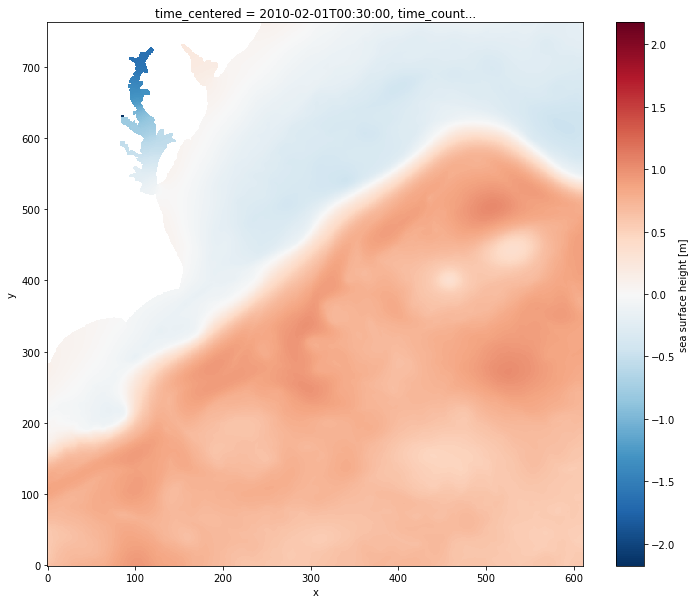

<xarray.Dataset>
Dimensions:       (x: 611, y: 763, z: 300)
Dimensions without coordinates: x, y, z
Data variables: (12/44)
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    nav_lev       (z) float32 ...
    time_counter  float64 ...
    tmask         (z, y, x) int8 ...
    umask         (z, y, x) int8 ...
    ...            ...
    gdepv         (z, y, x) float32 ...
    gdepw_0       (z, y, x) float32 ...
    gdept_1d      (z) float64 ...
    gdepw_1d      (z) float64 ...
    e3t_1d        (z) float64 ...
    e3w_1d        (z) float64 ...
Attributes:
    file_name:  mesh_mask.nc
    TimeStamp:  13/07/2018 22:32:53 +0200 <xarray.Dataset>
Dimensions:        (time_counter: 24, x: 611, y: 763)
Coordinates:
    nav_lat        (y, x) float32 ...
    nav_lon        (y, x) float32 ...
    time_centered  (time_counter) datetime64[ns] ...
  * time_counter   (time_counter) datetime64[ns] 2010-02-01T00:30:00 ... 2010...
Dimensions without coordinates: x, y
Data variab

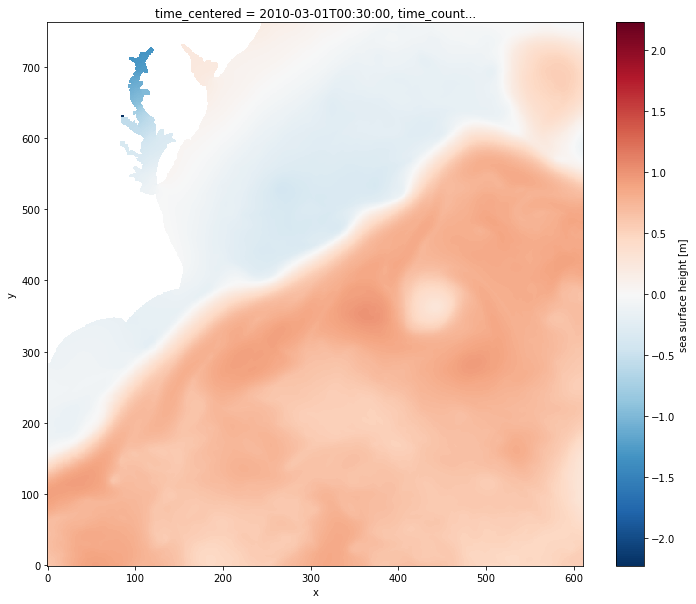

<xarray.Dataset>
Dimensions:       (x: 611, y: 763, z: 300)
Dimensions without coordinates: x, y, z
Data variables: (12/44)
    nav_lon       (y, x) float32 -78.01 -77.99 -77.97 ... -68.04 -68.02 -68.0
    nav_lat       (y, x) float32 30.0 30.0 30.0 30.0 ... 39.99 39.99 39.99 39.99
    nav_lev       (z) float32 ...
    time_counter  float64 ...
    tmask         (z, y, x) int8 ...
    umask         (z, y, x) int8 ...
    ...            ...
    gdepv         (z, y, x) float32 ...
    gdepw_0       (z, y, x) float32 ...
    gdept_1d      (z) float64 ...
    gdepw_1d      (z) float64 ...
    e3t_1d        (z) float64 ...
    e3w_1d        (z) float64 ...
Attributes:
    file_name:  mesh_mask.nc
    TimeStamp:  13/07/2018 22:32:53 +0200 <xarray.Dataset>
Dimensions:        (time_counter: 24, x: 611, y: 763)
Coordinates:
    nav_lat        (y, x) float32 ...
    nav_lon        (y, x) float32 ...
    time_centered  (time_counter) datetime64[ns] ...
  * time_counter   (time_counter) datetime64

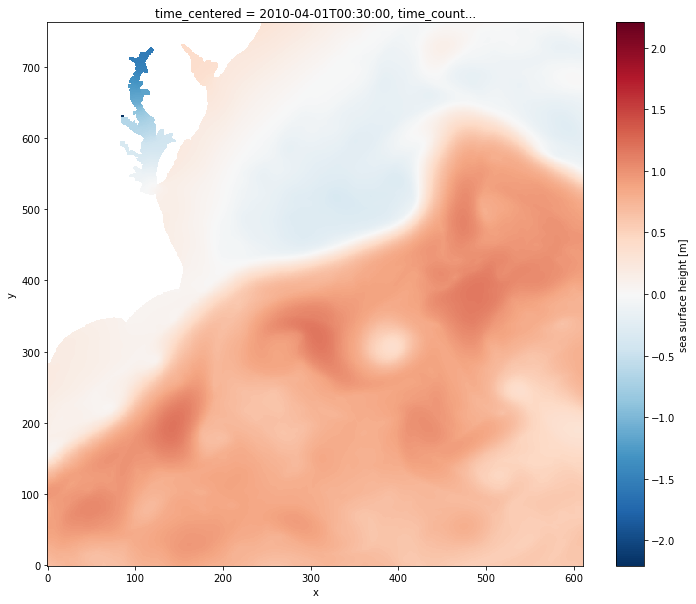

<xarray.Dataset>
Dimensions:       (x: 611, y: 763, z: 300)
Dimensions without coordinates: x, y, z
Data variables: (12/44)
    nav_lon       (y, x) float32 -78.01 -77.99 -77.97 ... -68.04 -68.02 -68.0
    nav_lat       (y, x) float32 30.0 30.0 30.0 30.0 ... 39.99 39.99 39.99 39.99
    nav_lev       (z) float32 ...
    time_counter  float64 ...
    tmask         (z, y, x) int8 ...
    umask         (z, y, x) int8 ...
    ...            ...
    gdepv         (z, y, x) float32 ...
    gdepw_0       (z, y, x) float32 ...
    gdept_1d      (z) float64 ...
    gdepw_1d      (z) float64 ...
    e3t_1d        (z) float64 ...
    e3w_1d        (z) float64 ...
Attributes:
    file_name:  mesh_mask.nc
    TimeStamp:  13/07/2018 22:32:53 +0200 <xarray.Dataset>
Dimensions:        (time_counter: 24, x: 611, y: 763)
Coordinates:
    nav_lat        (y, x) float32 ...
    nav_lon        (y, x) float32 ...
    time_centered  (time_counter) datetime64[ns] ...
  * time_counter   (time_counter) datetime64

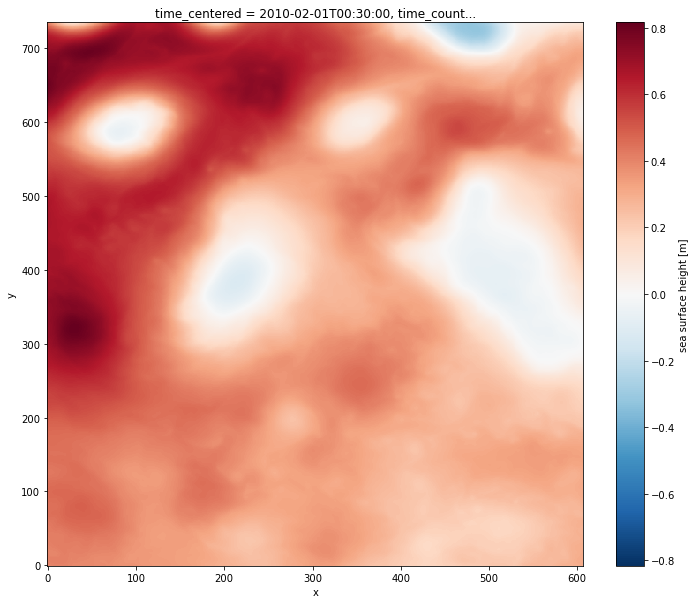

<xarray.Dataset>
Dimensions:       (x: 607, y: 735, z: 300)
Dimensions without coordinates: x, y, z
Data variables: (12/44)
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    nav_lev       (z) float32 ...
    time_counter  float64 ...
    tmask         (z, y, x) int8 ...
    umask         (z, y, x) int8 ...
    ...            ...
    gdepv         (z, y, x) float32 ...
    gdepw_0       (z, y, x) float32 ...
    gdept_1d      (z) float64 ...
    gdepw_1d      (z) float64 ...
    e3t_1d        (z) float64 ...
    e3w_1d        (z) float64 ...
Attributes:
    file_name:  mesh_mask.nc
    TimeStamp:  13/07/2018 22:32:53 +0200 <xarray.Dataset>
Dimensions:        (time_counter: 24, x: 607, y: 735)
Coordinates:
    nav_lat        (y, x) float32 ...
    nav_lon        (y, x) float32 ...
    time_centered  (time_counter) datetime64[ns] ...
  * time_counter   (time_counter) datetime64[ns] 2010-02-01T00:30:00 ... 2010...
Dimensions without coordinates: x, y
Data variab

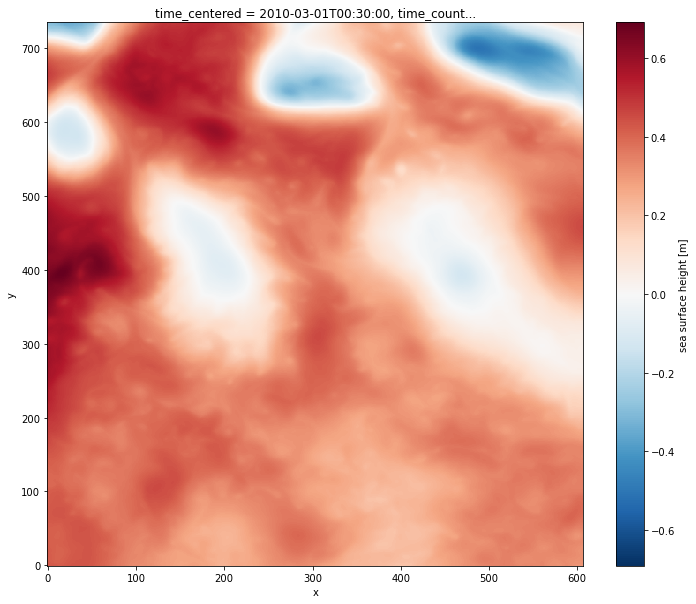

<xarray.Dataset>
Dimensions:       (x: 607, y: 735, z: 300)
Dimensions without coordinates: x, y, z
Data variables: (12/44)
    nav_lon       (y, x) float32 -53.51 -53.49 -53.48 ... -43.54 -43.52 -43.51
    nav_lat       (y, x) float32 30.49 30.49 30.49 30.49 ... 40.49 40.49 40.49
    nav_lev       (z) float32 ...
    time_counter  float64 ...
    tmask         (z, y, x) int8 ...
    umask         (z, y, x) int8 ...
    ...            ...
    gdepv         (z, y, x) float32 ...
    gdepw_0       (z, y, x) float32 ...
    gdept_1d      (z) float64 ...
    gdepw_1d      (z) float64 ...
    e3t_1d        (z) float64 ...
    e3w_1d        (z) float64 ...
Attributes:
    file_name:  mesh_mask.nc
    TimeStamp:  13/07/2018 22:32:53 +0200 <xarray.Dataset>
Dimensions:        (time_counter: 24, x: 607, y: 735)
Coordinates:
    nav_lat        (y, x) float32 ...
    nav_lon        (y, x) float32 ...
    time_centered  (time_counter) datetime64[ns] ...
  * time_counter   (time_counter) datetime64[

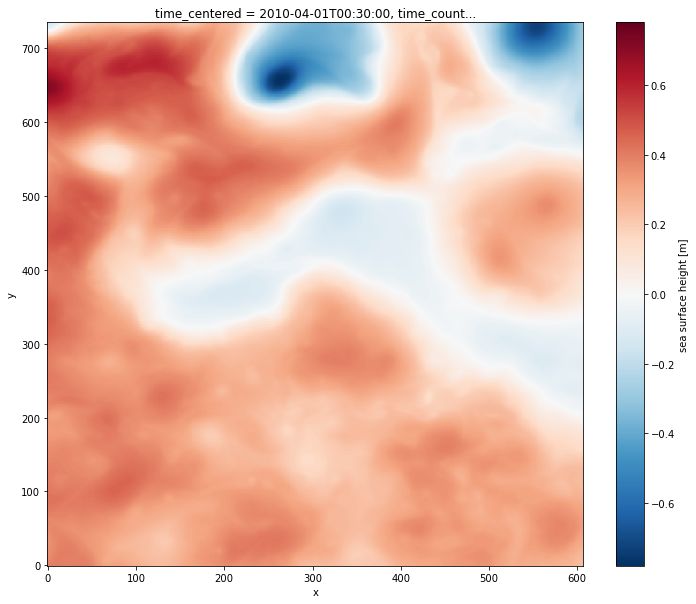

<xarray.Dataset>
Dimensions:       (x: 607, y: 735, z: 300)
Dimensions without coordinates: x, y, z
Data variables: (12/44)
    nav_lon       (y, x) float32 -53.51 -53.49 -53.48 ... -43.54 -43.52 -43.51
    nav_lat       (y, x) float32 30.49 30.49 30.49 30.49 ... 40.49 40.49 40.49
    nav_lev       (z) float32 ...
    time_counter  float64 ...
    tmask         (z, y, x) int8 ...
    umask         (z, y, x) int8 ...
    ...            ...
    gdepv         (z, y, x) float32 ...
    gdepw_0       (z, y, x) float32 ...
    gdept_1d      (z) float64 ...
    gdepw_1d      (z) float64 ...
    e3t_1d        (z) float64 ...
    e3w_1d        (z) float64 ...
Attributes:
    file_name:  mesh_mask.nc
    TimeStamp:  13/07/2018 22:32:53 +0200 <xarray.Dataset>
Dimensions:        (time_counter: 24, x: 607, y: 735)
Coordinates:
    nav_lat        (y, x) float32 ...
    nav_lon        (y, x) float32 ...
    time_centered  (time_counter) datetime64[ns] ...
  * time_counter   (time_counter) datetime64[

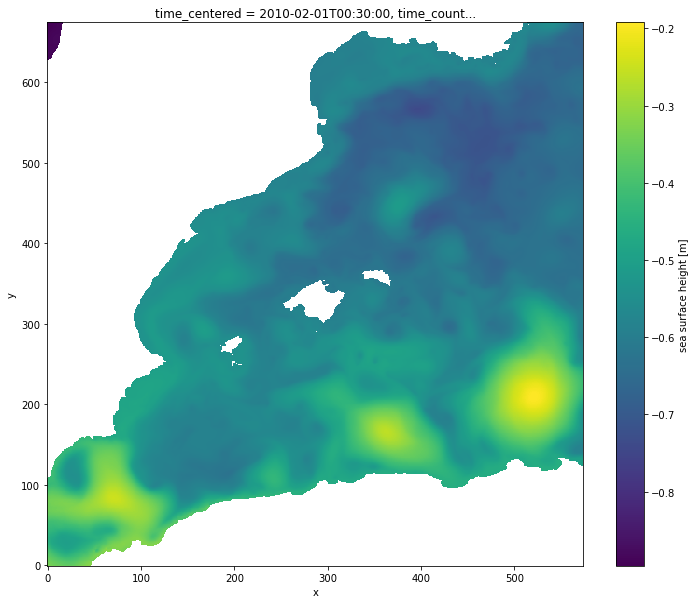

<xarray.Dataset>
Dimensions:       (x: 574, y: 675, z: 300)
Dimensions without coordinates: x, y, z
Data variables: (12/44)
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    nav_lev       (z) float32 ...
    time_counter  float64 ...
    tmask         (z, y, x) int8 ...
    umask         (z, y, x) int8 ...
    ...            ...
    gdepv         (z, y, x) float32 ...
    gdepw_0       (z, y, x) float32 ...
    gdept_1d      (z) float64 ...
    gdepw_1d      (z) float64 ...
    e3t_1d        (z) float64 ...
    e3w_1d        (z) float64 ...
Attributes:
    file_name:  mesh_mask.nc
    TimeStamp:  13/07/2018 22:32:53 +0200 <xarray.Dataset>
Dimensions:        (time_counter: 24, x: 574, y: 675)
Coordinates:
    nav_lat        (y, x) float32 ...
    nav_lon        (y, x) float32 ...
    time_centered  (time_counter) datetime64[ns] ...
  * time_counter   (time_counter) datetime64[ns] 2010-02-01T00:30:00 ... 2010...
Dimensions without coordinates: x, y
Data variab

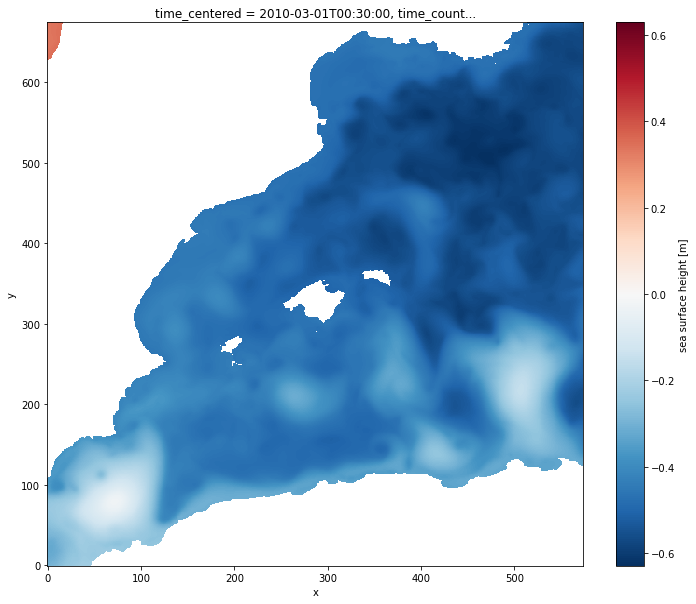

<xarray.Dataset>
Dimensions:       (x: 574, y: 675, z: 300)
Dimensions without coordinates: x, y, z
Data variables: (12/44)
    nav_lon       (y, x) float32 -2.001 -1.984 -1.968 ... 7.965 7.982 7.999
    nav_lat       (y, x) float32 35.49 35.49 35.49 35.49 ... 43.5 43.5 43.5 43.5
    nav_lev       (z) float32 ...
    time_counter  float64 ...
    tmask         (z, y, x) int8 ...
    umask         (z, y, x) int8 ...
    ...            ...
    gdepv         (z, y, x) float32 ...
    gdepw_0       (z, y, x) float32 ...
    gdept_1d      (z) float64 ...
    gdepw_1d      (z) float64 ...
    e3t_1d        (z) float64 ...
    e3w_1d        (z) float64 ...
Attributes:
    file_name:  mesh_mask.nc
    TimeStamp:  13/07/2018 22:32:53 +0200 <xarray.Dataset>
Dimensions:        (time_counter: 24, x: 574, y: 675)
Coordinates:
    nav_lat        (y, x) float32 ...
    nav_lon        (y, x) float32 ...
    time_centered  (time_counter) datetime64[ns] ...
  * time_counter   (time_counter) datetime64[n

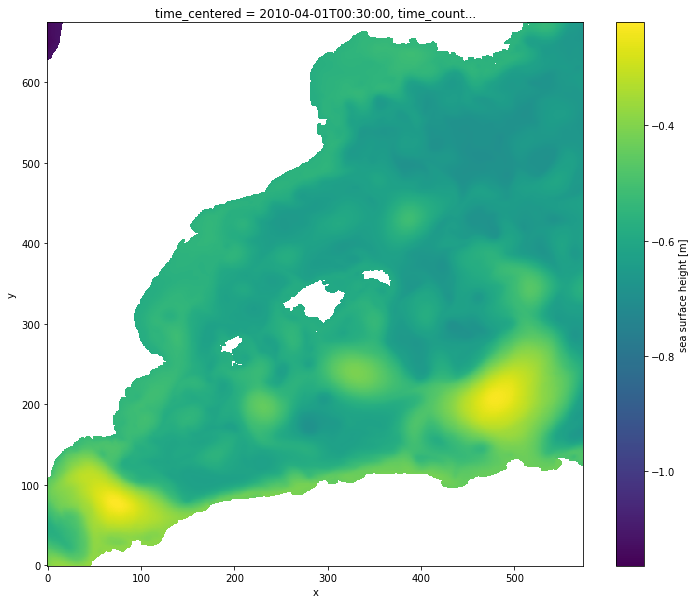

<xarray.Dataset>
Dimensions:       (x: 574, y: 675, z: 300)
Dimensions without coordinates: x, y, z
Data variables: (12/44)
    nav_lon       (y, x) float32 -2.001 -1.984 -1.968 ... 7.965 7.982 7.999
    nav_lat       (y, x) float32 35.49 35.49 35.49 35.49 ... 43.5 43.5 43.5 43.5
    nav_lev       (z) float32 ...
    time_counter  float64 ...
    tmask         (z, y, x) int8 ...
    umask         (z, y, x) int8 ...
    ...            ...
    gdepv         (z, y, x) float32 ...
    gdepw_0       (z, y, x) float32 ...
    gdept_1d      (z) float64 ...
    gdepw_1d      (z) float64 ...
    e3t_1d        (z) float64 ...
    e3w_1d        (z) float64 ...
Attributes:
    file_name:  mesh_mask.nc
    TimeStamp:  13/07/2018 22:32:53 +0200 <xarray.Dataset>
Dimensions:        (time_counter: 24, x: 574, y: 675)
Coordinates:
    nav_lat        (y, x) float32 ...
    nav_lon        (y, x) float32 ...
    time_centered  (time_counter) datetime64[ns] ...
  * time_counter   (time_counter) datetime64[n

In [12]:
year = 2010
rr = 1

for region in regions[int(rr-1):]:

    ys,ye = regionsy[rr-1]
    xs,xe = regionsx[rr-1]

    dsmask = xr.open_dataset(op.join(ddir,'../eNATL60-I/mesh_mask_eNATL60_3.6.nc')
                            ).isel(t=0,y=slice(ys,ye+1),x=slice(xs,xe+1))
    gdepw = xr.open_dataset(op.join(scratch,'gdepw_eNATL60.nc')
                           ).gdepw.isel(y=slice(ys,ye+1),x=slice(xs,xe+1))
    
    if region == 'NANFL':
        months = list(mandd.keys())[0:]
    else:
        months = list(mandd.keys())
    # months = list(mandd.keys())
    for mm in months:
        for dd in mandd[mm]:
            nvar = 0
            for variable in variables:
                if variable[-1] == 'y':
                    mask = dsmask.vmask.isel(z=0)
                elif variable[-1] == 'x':
                    mask = dsmask.umask.isel(z=0)
                else:
                    mask = dsmask.tmask.isel(z=0)
                if len(region) == 7:
                    try:
                        var = xr.open_dataset(op.join(adac,
                                    'Surface/BLBT02/%7s/eNATL60%7s-BLBT02_y%4dm%02dd%02d.1h_%8s.nc'
                                                      % (region,region,year,int(mm),dd,variable))
                                             )[variable]
                    except:
                        var = xr.open_dataset(op.join(adac,
                                    'Surface/BLBT02/%7s/eNATL60%7s-BLBT02_y%4dm%02dd%02d.1h_%6s.nc'
                                                      % (region,region,year,int(mm),dd,variable))
                                             )[variable]
                else:
                    try:
                        var = xr.open_dataset(op.join(adac,
                                    'Surface/BLBT02/%5s/eNATL60%5s-BLBT02_y%4dm%02dd%02d.1h_%8s.nc'
                                                      % (region,region,year,int(mm),dd,variable))
                                             )[variable]
                    except:
                        var = xr.open_dataset(op.join(adac,
                                    'Surface/BLBT02/%5s/eNATL60%5s-BLBT02_y%4dm%02dd%02d.1h_%6s.nc'
                                                      % (region,region,year,int(mm),dd,variable))
                                             )[variable]
                
                if variable == variables[0]:
                    if dd == mandd[mm][0]:
                        fig, ax  = plt.subplots(figsize=(12,10))
                        var.where(mask!=0.).isel(time_counter=0).plot(ax=ax)
                        plt.show()
                    tmp = var.where(mask!=0.).to_dataset(name=variable)
                else:
                    tmp[variable] = var.where(mask!=0.)
                del var
                nvar += 1
                        
            if dd == mandd[mm][0]:
                print(dsmask, tmp)
                dsave = tmp
            else:
                dsave = xr.concat([dsave, tmp], 'time_counter')
            tmp.close()
            del tmp
    
        dsave['tmask'] = xr.DataArray(dsmask.tmask.isel(z=0).data,
                                      dims=dsave.sosstsst.isel(time_counter=0).dims, 
                                      coords=dsave.sosstsst.isel(time_counter=0).coords
                                     )
        dsave['umask'] = xr.DataArray(dsmask.umask.isel(z=0).data,
                                      dims=dsave.sozocrtx.isel(time_counter=0).dims, 
                                      coords=dsave.sozocrtx.isel(time_counter=0).coords
                                     )
        dsave['vmask'] = xr.DataArray(dsmask.vmask.isel(z=0).data,
                                      dims=dsave.somecrty.isel(time_counter=0).dims, 
                                      coords=dsave.somecrty.isel(time_counter=0).coords
                                     )
        dsave['fmask'] = xr.DataArray(dsmask.fmask.isel(z=0).data,
                                      dims=dsave.sosstsst.isel(time_counter=0).dims, 
                                      coords=dsave.sosstsst.isel(time_counter=0).coords
                                     )
        # dsave.coords['time_counter'] = ('time_counter',np.arange(np.datetime64("%4d-%02d-%02dT00:30" 
        #                                                                        % (year,int(mm),1)), 
        #                                                          np.datetime64("%4d-%02d-%02dT00:00" 
        #                                                                        % (year,int(mm)+1,1)), 
        #                                                          np.timedelta64(1,'h'), dtype='datetime64[h]'))
        dsave.coords['depth'] = (('y','x'),gdepw)
        dsave.coords['lat'] = (('y','x'),dsmask.nav_lat)
        dsave.coords['lon'] = (('y','x'),dsmask.nav_lon)
        dsave.coords['e1t'] = (('y','x'),dsmask.e1t)
        dsave.coords['e2t'] = (('y','x'),dsmask.e2t)
        dsave.coords['e1f'] = (('y','x'),dsmask.e1f)
        dsave.coords['e2f'] = (('y','x'),dsmask.e2f)
        dsave.coords['e1u'] = (('y','x'),dsmask.e1u)
        dsave.coords['e2u'] = (('y','x'),dsmask.e2u)
        dsave.coords['e1v'] = (('y','x'),dsmask.e1v)
        dsave.coords['e2v'] = (('y','x'),dsmask.e2v)

        if len(region) == 7:
            dsave.to_netcdf(op.join(adac,'Surface/BLBT02/%7s/Region%02d-surface-hourly_%4d-%02d.nc'
                                    % (region,rr,year,int(mm)))
                           )
        else:
            dsave.to_netcdf(op.join(adac,'Surface/BLBT02/%5s/Region%02d-surface-hourly_%4d-%02d.nc'
                                    % (region,rr,year,int(mm)))
                           )
        print(dsave)
        dsave.close()
        del dsave
    rr += 1

In [13]:
client.close()